data download <br>
http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz <br>
https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

In [1]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

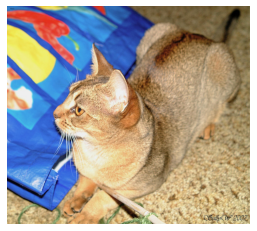

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

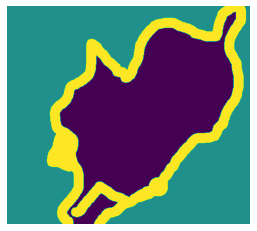

In [3]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)
# img의 각셀은 1-3의 값을 갖음

In [4]:
import numpy as np
import random
img_size = (200, 200)
num_imgs = len(input_img_paths)

In [5]:
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [6]:
input_imgs.shape

(7390, 200, 200, 3)

In [7]:
targets.shape

(7390, 200, 200, 1)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

# 모형 생성하기
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    # 인코더 부분
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # 디코더 부분
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x) # 채널의 수 = 클래스의 수, 채널기준으로 softmax 적용
    # https://stackoverflow.com/questions/46771597/softmax-layer-in-keras-returns-a-vector-of-1s
    # The softmax activation will be applied to the last axis.
    # (None, 200, 200, 3)에서 3에 적용!
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [11]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy']) # 정수형태의 타겟을 받아서 categorical_crossentropy를 적용

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=20,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/20
100/100 [==============================] - 931s 9s/step - loss: 0.5461 - accuracy: 0.7979 - val_loss: 0.5166 - val_accuracy: 0.7908
Epoch 2/20
100/100 [==============================] - 922s 9s/step - loss: 0.4681 - accuracy: 0.8156 - val_loss: 0.4753 - val_accuracy: 0.8163
Epoch 3/20
100/100 [==============================] - 923s 9s/step - loss: 0.4674 - accuracy: 0.8169 - val_loss: 0.5001 - val_accuracy: 0.8096
Epoch 4/20
100/100 [==============================] - 12071s 122s/step - loss: 0.4459 - accuracy: 0.8268 - val_loss: 0.4335 - val_accuracy: 0.8314
Epoch 5/20
100/100 [==============================] - 927s 9s/step - loss: 0.4358 - accuracy: 0.8298 - val_loss: 0.4126 - val_accuracy: 0.8393
Epoch 6/20
100/100 [==============================] - 922s 9s/step - loss: 0.4203 - accuracy: 0.8360 - val_loss: 0.4153 - val_accuracy: 0.8370
Epoch 7/20
100/100 [==============================] - 921s 9s/step - loss: 0.4111 - accuracy: 0.8396 - val_loss: 0.4020 - val_accuracy: 0.

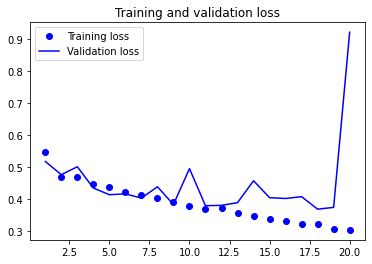

In [12]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

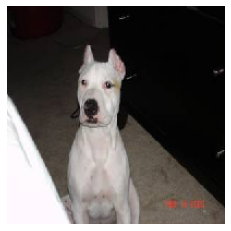

In [14]:
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

1/1 [==============================] - 0s 180ms/step


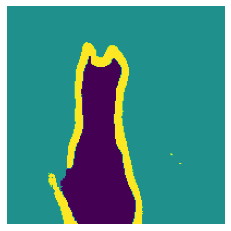

In [15]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)